# Document Analysis
This notebook explores the individual documents within the dam removal database literature corpus. 

In [1]:
import re
import nltk
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup      
from tika import parser
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
%matplotlib notebook

# Data
Pre-processing document strings to remove numerical characters, convert to lowercase and remove english stopwords. Using apache tika for ocr and parsing for the PDFs. Failed documents will print an exception and the title of the document

In [2]:
raw_corpus_list = os.listdir('../data/pdf/')

In [3]:
'''
Removing non-letters, lowercase and removing stopwords
'''
def clean_doc_data(raw_review):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_review) 
    words = letters_only.lower().split()                             
    stops = set(stopwords.words("english"))                  
    meaningful_words = [w for w in words if not w in stops]   
    return(" ".join(meaningful_words))

In [25]:
'''
Using tika to parse pdfs and placing into doc_text list by document
limited to 50 results
'''
doc_labels = []
doc_text = []
for file in raw_corpus_list:
    if file.endswith('.pdf'):
        try:
            text = parser.from_file('../data/pdf/' + file)
            tmp = clean_doc_data(text['content'])
            doc_text.append(tmp)
            doc_labels.append(file)
            print('O -' + str(file))
        except Exception as e:
            print('X - ' + str(e) + ' --- ' + str(file))

O -Ahearn_Dahlgren_2005_Limnology and Oceanography.pdf
O -Amos_2008_Thesis.pdf
O -Ashley et al._2006_Environmental Monitoring and Assessment.pdf
O -Berthelote_2013_Thesis.pdf
O -Bountry_etal_2013_Reviews in Engineering Geology.pdf
O -Bowman_2001_Thesis.pdf
O -Brazell_Cole_2009_Journal of the Pennsylvania Academy of Science.pdf
O -Bulak_etal_2011_Report.pdf
O -Burdick,_Hightower_2006_Transactions of the American Fisheries Society.pdf
O -Burroughs_2003_Thesis.pdf
O -Burroughs_2007_Thesis_Ch2.pdf
O -Burroughs_2007_Thesis_Ch3.pdf
O -Burroughs_etal_2009_Geomorphology.pdf
O -Burroughs_etal_2010_TransactionsOfTheAmericanFisheriesSociety.pdf
X - 'latin-1' codec can't encode character '\u2010' in position 27: ordinal not in range(256) --- Bushaw‐Newton_etal_2003_JAWRA.pdf
O -Cannatelli_Curran_2012_Journal of Hydraulic Engineering.pdf
O -Cantwell_etal_2014_Environmental monitoring and assessment.pdf
O -Casper_etal_2006_Archiv fuer Hydrobiologie Supplement.pdf
O -Catalano_2002_Thesis.pdf
O -Catal

In [5]:
# convert to array
doc_data = np.array(doc_text)
doc_data.shape

(49,)

## Term Frequency-Inverse Document Frequency
Numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [6]:
vectorizer = TfidfVectorizer(min_df=1, stop_words='english', analyzer='word', ngram_range=(0,3))
vectorizer.fit_transform(doc_data)

<49x528965 sparse matrix of type '<class 'numpy.float64'>'
	with 664474 stored elements in Compressed Sparse Row format>

In [7]:
vect = vectorizer.fit_transform(doc_data)
mat_array = vect.toarray()
feat_names = vectorizer.get_feature_names()

In [8]:
ifidf_analysis = []
for idx, i in enumerate(mat_array):
    print(doc_labels[idx])
    print([(feat_names[x], i[x]) for x in (i*-1).argsort()][:10])
    ifidf_analysis.append((doc_labels[idx], [(feat_names[x], i[x]) for x in (i*-1).argsort()][:10]))

Ahearn_Dahlgren_2005_Limnology and Oceanography.pdf
[('', 0.98891418340572212), ('restored reach', 0.049212503873269829), ('restored', 0.027742999827489494), ('sediment', 0.026942516482428732), ('dam', 0.024615769413100511), ('fig', 0.023654007574392521), ('removal', 0.023346915319641722), ('nh', 0.021974423216704633), ('reach', 0.018867358441834077), ('export', 0.01816618530149218)]
Amos_2008_Thesis.pdf
[('', 0.9893058102969492), ('channel', 0.034348277151654408), ('headcut', 0.026083503383377546), ('figure', 0.023904710839163235), ('shear', 0.022139210332658449), ('dam', 0.018537700132632076), ('mm', 0.017113726556134693), ('mm mm', 0.016052677681122444), ('channel shear', 0.015837849250691767), ('bankfull', 0.015353371005932426)]
Ashley et al._2006_Environmental Monitoring and Assessment.pdf
[('', 0.9892220134598706), ('removal', 0.03061169045487289), ('pahs', 0.029141402878717314), ('dam', 0.023975589726893457), ('dw', 0.022636571379800328), ('contaminant', 0.021386903371791152), (

#### Most Important Terms for Document 1

In [34]:
ifidf_analysis[0]

('Ahearn_Dahlgren_2005_Limnology and Oceanography.pdf',
 [('', 0.98891418340572212),
  ('restored reach', 0.049212503873269829),
  ('restored', 0.027742999827489494),
  ('sediment', 0.026942516482428732),
  ('dam', 0.024615769413100511),
  ('fig', 0.023654007574392521),
  ('removal', 0.023346915319641722),
  ('nh', 0.021974423216704633),
  ('reach', 0.018867358441834077),
  ('export', 0.01816618530149218)])

### PST and PDT

In [21]:
pdt = []
for i in ifidf_analysis:
    doc_id = i[0]
    words = i[1]
    
    for word in words:
        if 'pdt' in word[0]:
            print(doc_id, word)
        if 'pst' in word[0]:
            print(doc_id, word)

Curran_etal_2014_Report.pdf ('pdt', 0.50042372934717694)
Curran_etal_2014_Report.pdf ('pdt pdt', 0.50037951546876402)
Curran_etal_2014_Report.pdf ('pdt pdt pdt', 0.50033530159035111)
Curran_etal_2014_Report.pdf ('pst', 0.26702971867490782)
Curran_etal_2014_Report.pdf ('pst pst', 0.26700761173570137)
Curran_etal_2014_Report.pdf ('pst pst pst', 0.26698550479649485)
Evans_etal_2007_JAWRA.pdf ('upstream', 0.015555711469052064)


In [33]:
'''
DO NOT RUN
Catalano_2002_Thesis.pdf
Curran_etal_2014_Report.pdf
DeShon_2010_Report.pdf
Keith_2012_Thesis.pdf
Major_etal_2008_EOS.pdf
Major_etal_2010_Report.pdf
Major_etal_2012_Professional Paper.pdf
-- check for dan for docs w/ high frequency of pdt or pst

print(len(doc_text))
for idx, i in enumerate(doc_text):
    ct = 0
    for word in i:
        if 'pdt ' in i:
            ct += 1
        if 'pst ' in i:
            ct +=1
    if ct > 30:
        print(doc_labels[idx])
'''

166
Catalano_2002_Thesis.pdf
Curran_etal_2014_Report.pdf
DeShon_2010_Report.pdf
Keith_2012_Thesis.pdf
Major_etal_2008_EOS.pdf
Major_etal_2010_Report.pdf
Major_etal_2012_Professional Paper.pdf


## Document Clustering 

In [36]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters)

%time km.fit(vect)
clusters = km.labels_.tolist()

CPU times: user 7.58 s, sys: 383 ms, total: 7.97 s
Wall time: 8.05 s


### Plot

<IPython.core.display.Javascript object>


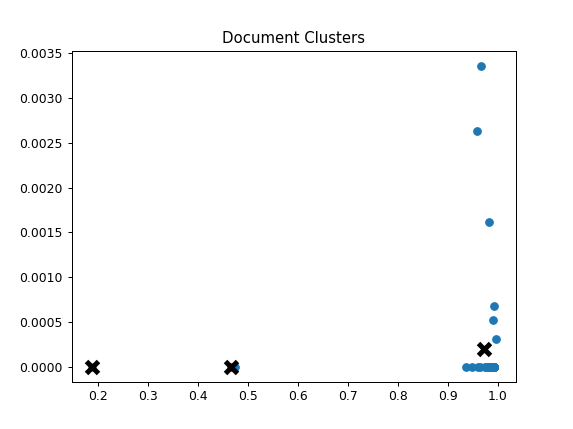

In [38]:
labels = km.labels_
centroids = km.cluster_centers_

fig, axes = plt.subplots()
for i in range(num_clusters):
    # select only data observations with cluster label == i
    ds = mat_array[np.where(labels == i)]
    
    plt.plot(ds[:,0], ds[:,1], 'o') # plt observations

    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')  # plt centroid

    plt.setp(lines,ms=10.0) # size of centroid
    plt.setp(lines,mew=4.0) # line width
    plt.title('Document Clusters')
plt.show()